In [3]:
import numpy as np
import torch as th
import os
%load_ext autoreload
%autoreload 2
from PIL import Image 
from IPython.display import clear_output
from matplotlib.pyplot import imshow 
import matplotlib.pyplot as plt
import PIL
import torch

from itertools import islice
from torchvision.transforms.functional import to_tensor

import pandas as pd
from torchvision import transforms
from itertools import product
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Add path to project 

In [4]:
import sys
sys.path
sys.path.append('/home/vage/PycharmProjects/Deep-vectorization-P.R./')

In [5]:
from util_files.rendering.cairo  import render,render_with_skeleton
from util_files.data.graphics_primitives import PT_LINE,  PT_CBEZIER, PT_QBEZIER
import  util_files.loss_functions.supervised  as supervised_loss 
from util_files.optimization.optimizer.scheduled_optimizer import ScheduledOptimizer
import util_files.dataloading as dataloading
from vectorization import load_model
from util_files.patchify import patchify
from util_files.geometric import liang_barsky_screen
from util_files.rendering.cairo import render

/home/vage/anaconda3/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


# Parameters

In [6]:
device = torch.device('cuda:{}'.format(0))
prefetch_data = True
batches_completed_in_epoch=0
epoch_size = 20000
curve_count = 10
model_type = "model"

In [7]:
import sys; sys.argv=['']; del sys
import argparse

def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--output_dir', type=str, default="/home/vage/Downloads/testing_line/", help='dir to folder for output')
    parser.add_argument('--diff_render_it', type=int, default=200, help='iteration count')
    parser.add_argument('--init_random', action='store_true', default=False, dest='init_random',
                        help='init model with random [default: False].')
    parser.add_argument('--rendering_type', type=str, default='hard', help='hard -oleg,simple Alexey')
    parser.add_argument('--data_dir', type=str, default="/home/vage/Downloads/abc/", help='dir to folder for input')
    parser.add_argument('--image_name', type=str, default="00050000_99fd5beca7714bc586260b6a_step_000.png",
                        help='Name of image.If None will perform to all images in '
                             'folder.[default: None]')
    parser.add_argument('--overlap', type=int, default=0, help='overlap in pixel')
    parser.add_argument('--model_output_count', type=int, default=10, help='max_model_output')
    
    return parser.parse_args()

In [8]:
options = parse_args()

# Read image/dataset

In [9]:
def preprocess_image(image):
    patch_height, patch_width = image.shape[1:3]
    image = torch.as_tensor(image).type(torch.float32).reshape(-1, patch_height, patch_width) / 255
    image = 1 - image  # 0 -- background
    mask = (image > 0).type(torch.float32)
    _xs = np.arange(1, patch_width + 1, dtype=np.float32)[None].repeat(patch_height, 0) / patch_width
    _ys = np.arange(1, patch_height + 1, dtype=np.float32)[..., None].repeat(patch_width, 1) / patch_height
    _xs = torch.from_numpy(_xs)[None]
    _ys = torch.from_numpy(_ys)[None]
    return torch.stack([image, _xs * mask, _ys * mask], dim=1)

In [10]:
def read_data(options, image_type = 'RGB'):
    train_transform = transforms.Compose([
        # something wrong with current model in vertical lines add random rotate if you need results too be better
#         transforms.RandomRotation(degrees = (2,5),fill=255),
        transforms.ToTensor(),
    ])
    dataset = []
    if options.image_name is None:
        image_names = os.listdir(options.data_dir)
        print(image_names)
        for image_name in image_names:
            if (image_name[-4:] != 'jpeg' and image_name[-3:] != 'png' and image_name[-3:] != 'jpg') or image_name[0]=='.':
                print(image_name[-4:])
                continue
            
            img = train_transform(Image.open(options.data_dir + image_name).convert(image_type))
            print(img.shape)
            img_t = torch.ones(img.shape[0], img.shape[1] + (32 - img.shape[1] % 32),
                               img.shape[2] + (32 - img.shape[2] % 32))
            img_t[:, :img.shape[1], :img.shape[2]] = img
            dataset.append(img_t)
        options.image_name = image_names
    else:
        img = train_transform(Image.open(options.data_dir + options.image_name).convert(image_type))
        print(img)
        print(img.shape)
        img_t = torch.ones(img.shape[0], img.shape[1] + (32 - img.shape[1] % 32),
                           img.shape[2] + (32 - img.shape[2] % 32))
        img_t[:, :img.shape[1], :img.shape[2]] = img
        dataset.append(img_t)
        options.image_name = [options.image_name]

    return dataset

In [11]:
# options.image_name = options.image_name[0]
images = read_data(options,image_type='L')

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])
torch.Size([1, 2220, 2652])


In [12]:
options.sample_name=options.image_name[0]

In [13]:
images[0]

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])

In [14]:
image = images[0]

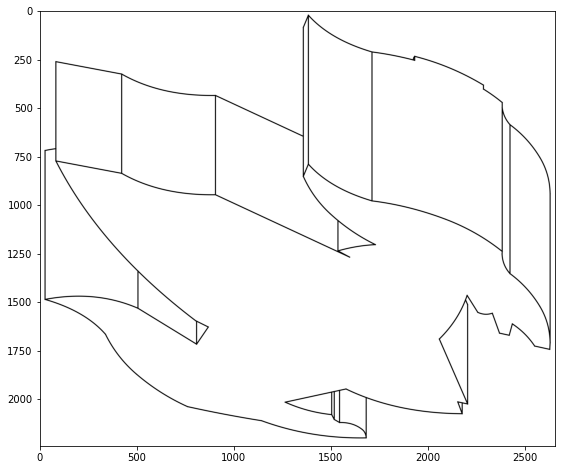

In [15]:
plt.figure(figsize=(12,8))
plt.imshow(image[0],'gray')

In [16]:
image

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])

# Model loading 

In [17]:
# in json file you can chose model type and it's parameters as in examples in vectorization/models/specs/ folder

In [18]:
# chose json file 
model_json_param = '/home/vage/PycharmProjects/Deep-vectorization-P.R./vectorization/models/specs/resnet18_blocks1_bn_64__c2h__trans_heads4_feat256_blocks8_ffmaps512__h2o__out512.json'
#load/create model 
model = load_model(model_json_param).to(device)

In [19]:
def serialize(checkpoint):
    model_state_dict = checkpoint['model_state_dict']
    keys = []
    for k in model_state_dict:
        if 'hidden.transformer' in k:
            keys.append(k)

    for k in keys:
        new_key = 'hidden.decoder.transformer' + k[len('hidden.transformer'):]
        model_state_dict[new_key] = model_state_dict[k]
        del model_state_dict[k]
    return checkpoint
checkpoint = serialize(torch.load("/home/vage/Downloads/02.03_safin/29.02_abc/model_curves.weights"))


model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

# Estimation of primitive 

In [20]:
def split_to_patches(rgb, patch_size, overlap=0):
    """Separates the input into square patches of specified size.

    :param rgb: input RGB image
    :type rgb: numpy.ndarray
    :param patch_size: size of patches in pixels (assuming
                        square patches)
    :type patch_size: int
    :param overlap: amount in pixels of how much the patches
                    can overlap with each other (useful for merging)
    :type overlap: int

    :returns patches, patches_offsets
    :rtype Tuple[numpy.ndarray, numpy.ndarray]
    """
    rgb = rgb.transpose(1, 2, 0)
    rgb_t = np.ones((rgb.shape[0] + 33, rgb.shape[1] + 33, rgb.shape[2])) * 255.
    rgb_t[:rgb.shape[0], :rgb.shape[1], :] = rgb
    rgb = rgb_t

    height, width, channels = rgb.shape

    assert patch_size > 0 and 0 <= overlap < patch_size
    patches = patchify(rgb,
                       patch_size=(patch_size, patch_size, channels),
                       step=patch_size - overlap)
    patches = patches.reshape((-1, patch_size, patch_size, channels))
    height_offsets = np.arange(0, height - patch_size, step=patch_size - overlap)
    width_offsets = np.arange(0, width - patch_size, step=patch_size - overlap)
    patches_offsets = np.array(list(
        product(height_offsets, width_offsets)
    ))
    return patches, patches_offsets, rgb

In [21]:
image_tensor = image.unsqueeze(0).to(device)
patches_rgb, patches_offsets, input_rgb = split_to_patches(image_tensor.cpu().numpy()[0] * 255, 64, options.overlap)

In [22]:
model.eval()
patches_vector = []
print('--- Preprocessing BEGIN')
patch_images = preprocess_image(patches_rgb)
print('--- Preprocessing END')

for it_batches in range(400, patch_images.shape[0] + 399, 400):
    it_start = it_batches - 400
    if it_batches > patch_images.shape[0]:
        it_batches = patch_images.shape[0]
    with torch.no_grad():
        if(it_start==0):
            patches_vector = model(patch_images[it_start:it_batches].cuda().float(), options.model_output_count).detach().cpu().numpy()
        else:
            patches_vector = np.concatenate((patches_vector,model(patch_images[it_start:it_batches].cuda().float(), options.model_output_count).detach().cpu().numpy()),axis=0)
patches_vector = torch.tensor(patches_vector) * 64

--- Preprocessing BEGIN
--- Preprocessing END


In [23]:
patches_vector.shape

torch.Size([1470, 10, 8])

In [24]:
a ={PT_QBEZIER:patches_vector[200]}
rendered_image = render(a,(64,64), data_representation='vahe',linecaps='round')

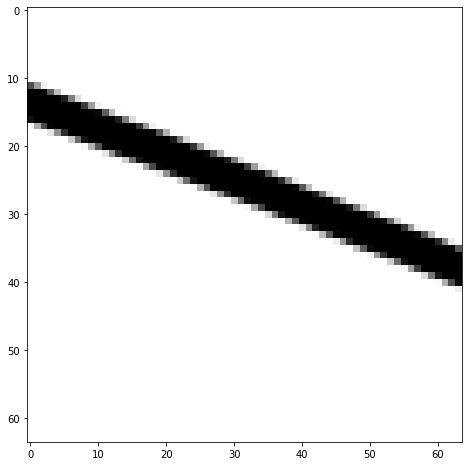

In [25]:
plt.figure(figsize=(12,8))
plt.imshow(rendered_image,"gray")

In [26]:
def assemble_vector_patches(patches_vector, patches_offsets):
    primitives = []
    i = 0
    for patch_vector, patch_offset in zip(patches_vector, patches_offsets):
        i += 1
        
        patch_vector[:, [0, 2, 4]] += patch_offset[1]
        

        patch_vector[:, [1, 3, 5]] += patch_offset[0]
        primitives.append(patch_vector)
    return np.array(primitives)


In [27]:
vect = assemble_vector_patches(np.array((patches_vector.reshape(-1, options.model_output_count, 8))),
                                   np.array(patches_offsets))
vect = vect.reshape(-1,8)
vect = vect[(vect[:, -2] > 0.3)]
vect = vect[(vect[:, -1] > 0.5)]

In [28]:
a ={PT_QBEZIER:vect}
rendered_image = render(a,(image.shape[2],(image.shape[1])), data_representation='vahe',linecaps='round')

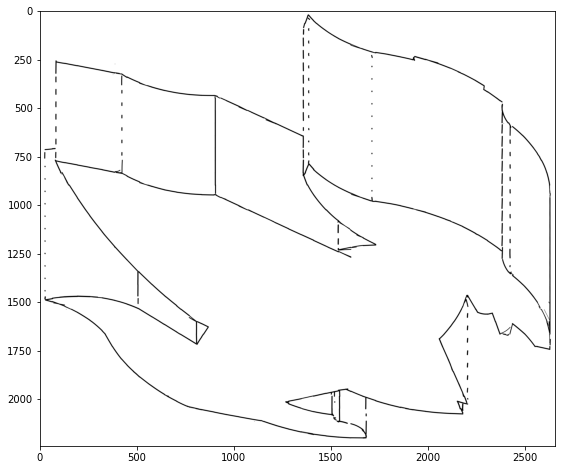

In [29]:
plt.figure(figsize=(12,8))
plt.imshow(rendered_image,"gray")

For some reson model failing to correctly predict vertical lines. One way to correct it, is to slighlty rotate image, another one is to retrain model or refine it on vertical lines.  
P.s. In the paper, all metrics was estimated with this bug, so correcting it may lead to better results.

# Refinement

In [30]:
control_points_n=3
dtype=torch.float32
intermediate_output ={'options':options,'patches_offsets':patches_offsets,
                      'patches_vector':patches_vector,
                      'cleaned_image_shape':(rendered_image.shape[0],rendered_image.shape[1]),
                     'patches_rgb':patches_rgb}


In [31]:
import os
import pickle
import sys
from time import time

import h5py
import numpy as np
import torch
from tqdm import trange


from util_files.optimization.optimizer.logging import Logger
from util_files.evaluation_utils import vector_image_from_patches

from util_files.optimization.optimizer.adam import Adam
from util_files.optimization.primitives.line_tensor import LineTensor
from util_files.optimization.primitives.quadratic_bezier_tensor import QuadraticBezierTensor
from util_files.optimization.parameters import min_linear_size
from util_files.simplification.join_qb import join_quad_beziers
from refinement.our_refinement.refinement_for_curves import main as curve_refinement

In [32]:
primitives_after_optimization, patch__optim_offsets,repatch_scale, optim_vector_image = curve_refinement(options,intermediate_output,optimization_iters_n=20)

2021-05-21 22:16:04,144 INFO: 1. Load intermediate output from /home/vage/Downloads/testing_line//intermediate_output/00050000_99fd5beca7714bc586260b6a_step_000.pickle
2021-05-21 22:16:04,148 INFO: 2.5. Repatch
2021-05-21 22:16:04,149 INFO: 	the width is 5.658815383911133
2021-05-21 22:16:04,149 INFO: 	the width percentile is 90
2021-05-21 22:16:04,149 INFO: 	repatch scale is 3


3
3


2021-05-21 22:16:09,107 INFO: 	168 patches left with max 10 primitives per patch
2021-05-21 22:16:09,107 INFO: 3. Filter out empty patches
2021-05-21 22:16:09,108 INFO: 	from 168 patches
2021-05-21 22:16:09,109 INFO: 	94 patches left
2021-05-21 22:16:09,109 INFO: 3.5. Sort patches
2021-05-21 22:16:09,111 INFO: 	94 patches left with max 10 primitives per patch
2021-05-21 22:16:09,112 INFO: 6. Optimization parameters
2021-05-21 22:16:09,112 INFO: 	primitive type is qbeziers
2021-05-21 22:16:09,112 INFO: 	primitive type of model outputs is qbeziers
2021-05-21 22:16:09,113 INFO: 	initialization is model
2021-05-21 22:16:09,114 INFO: 7. Prepare file with metrics at /home/vage/Downloads/testing_line//20/model_initialization/logs/00050000_99fd5beca7714bc586260b6a_step_000.h5
2021-05-21 22:16:09,118 INFO: 8. Optimization
2021-05-21 22:16:09,120 INFO: Optimize batches:   0%|          | 0/9 [00:00<?, ?it/s]
2021-05-21 22:16:09,120 INFO: 	Initialize
2021-05-21 22:16:09,125 INFO: 	optimize patches

2021-05-21 22:16:15,575 INFO: 	Initialize
2021-05-21 22:16:15,577 INFO: 	optimize patches 93-93:   0%|          | 0/20 [00:00<?, ?it/s]
2021-05-21 22:16:15,683 INFO: 	optimize patches 93-93:  10%|#         | 2/20 [00:00<00:00, 18.93it/s]
2021-05-21 22:16:15,790 INFO: 	optimize patches 93-93:  45%|####5     | 9/20 [00:00<00:00, 24.07it/s]
2021-05-21 22:16:15,898 INFO: 	optimize patches 93-93:  80%|########  | 16/20 [00:00<00:00, 29.64it/s]
2021-05-21 22:16:15,961 INFO: 	optimize patches 93-93: 100%|##########| 20/20 [00:00<00:00, 52.16it/s]
2021-05-21 22:16:15,962 INFO: Optimize batches: 100%|##########| 9/9 [00:06<00:00,  1.32it/s]
2021-05-21 22:16:15,963 INFO: 	Optimization took 6.844286203384399 seconds
2021-05-21 22:16:15,963 INFO: 9. Save optimization result to /home/vage/Downloads/testing_line//20/model_initialization/after_optimization/00050000_99fd5beca7714bc586260b6a_step_000.svg
/home/vage/PycharmProjects/Deep-vectorization-P.R./util_files/evaluation_utils.py:26: UserWarning: 

{'width': '2656px', 'height': '2240px', 'viewBox': '0 0 2656 2240', 'size': ('2656px', '2240px')}


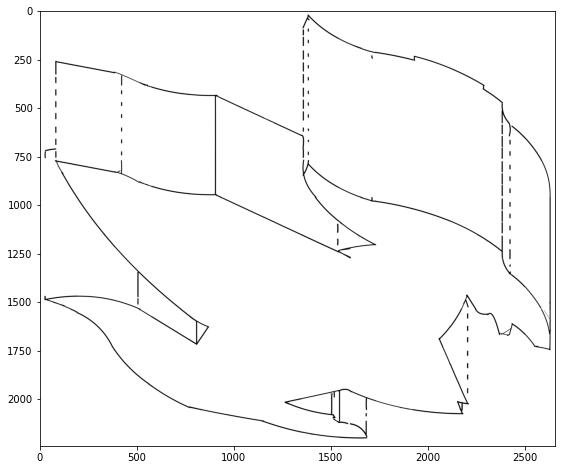

In [33]:
plt.figure(figsize=(12,8))
plt.imshow(optim_vector_image.render(render),"gray")

In [34]:
from merging.merging_for_curves import main as curve_merging

In [35]:
curve_merging(options,vector_image_from_optimization=optim_vector_image)

TypeError: main() got an unexpected keyword argument 'vector_image_from_optimization'